In [4]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym, os
from itertools import count
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [20]:
class Model(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(Model, self).__init__()
        self.affine = nn.Linear(state_dim, n_latent_var)
        
        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim = -1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
        # Memory:
        self.actions = []
        self.states = []
        self.logprobs = []
        self.state_values = []
        self.rewards = []
        
    def forward(self, state, action=None, evaluate=False):
        # if evaluate is True then we also need to pass an action for evaluation
        # else we return a new action from distribution
        if not evaluate:
            state = torch.from_numpy(state).float().to(device)
        
        state_value = self.value_layer(state)
        
        action_probs = self.action_layer(state)
        action_distribution = Categorical(action_probs)
        
        if not evaluate:
            action = action_distribution.sample()
            self.actions.append(action)
            
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        if evaluate:
            return action_distribution.entropy().mean()
        
        if not evaluate:
            return action.item()
        
    def clearMemory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [21]:
class PPO:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = Model(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(),
                                              lr=lr, betas=betas)
        self.policy_old = Model(state_dim, action_dim, n_latent_var).to(device)
        
        self.MseLoss = nn.MSELoss()
        
    def update(self):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward in reversed(self.policy_old.rewards):
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list in tensor
        old_states = torch.tensor(self.policy_old.states).to(device).detach()
        old_actions = torch.tensor(self.policy_old.actions).to(device).detach()
        old_logprobs = torch.tensor(self.policy_old.logprobs).to(device).detach()
        

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            dist_entropy = self.policy(old_states, old_actions, evaluate=True)
            # Finding the ratio (pi_theta / pi_theta__old):
            logprobs = self.policy.logprobs[0].to(device)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            

            # Finding Surrogate Loss:
            state_values = self.policy.state_values[0].to(device)
            advantages = rewards - state_values.squeeze().detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
            self.policy.clearMemory()
            
        self.policy_old.clearMemory()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        

In [5]:
############# Hyperparameters ##############
env_name = "LunarLander-v2"
# creating environment
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 4

n_episodes = 400
max_timesteps = 300
log_interval = 10
n_latent_var = 64           # number of variables in hidden layer
lr = 0.0007
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
random_seed = None
#############################################
if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

filename = "PPO_{}.pth".format(env_name)
directory = "./preTrained/"

Episode: 1	Reward: -71
Episode: 2	Reward: -261
Episode: 3	Reward: -147
Episode: 4	Reward: -96
Episode: 5	Reward: -331
Episode: 6	Reward: -152
Episode: 7	Reward: -281
Episode: 8	Reward: -82
Episode: 9	Reward: -140
Episode: 10	Reward: -94
Episode: 11	Reward: -75
Episode: 12	Reward: -405
Episode: 13	Reward: -114
Episode: 14	Reward: -270
Episode: 15	Reward: -85
Episode: 16	Reward: -121
Episode: 17	Reward: -68
Episode: 18	Reward: -297
Episode: 19	Reward: -100
Episode: 20	Reward: -540
Episode: 21	Reward: -111
Episode: 22	Reward: -265
Episode: 23	Reward: -341
Episode: 24	Reward: -122
Episode: 25	Reward: -279
Episode: 26	Reward: -249
Episode: 27	Reward: -261
Episode: 28	Reward: -258
Episode: 29	Reward: -354
Episode: 30	Reward: -388
Episode: 31	Reward: -94
Episode: 32	Reward: -185
Episode: 33	Reward: -219
Episode: 34	Reward: -255
Episode: 35	Reward: -116
Episode: 36	Reward: -185
Episode: 37	Reward: -183
Episode: 38	Reward: -85
Episode: 39	Reward: -113
Episode: 40	Reward: -25
Episode: 41	Reward:

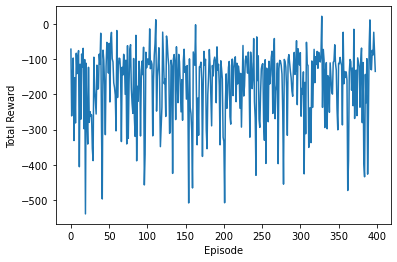

In [27]:
ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)

running_reward = 0
rewards = []
for ep in range(1, n_episodes+1):
    state = env.reset()
    for t in range(max_timesteps):
        # Running policy_old:
        action = ppo.policy_old(state)
        state_n, reward, done, _ = env.step(action)
        # Saving state and reward:
        ppo.policy_old.states.append(state)
        ppo.policy_old.rewards.append(reward)
        state = state_n

        running_reward +=reward 
        if done:
            # save model
            torch.save(ppo.policy.state_dict(), directory+filename)
            rewards.append(running_reward)
            break
    
    
    print('Episode: {}\tReward: {}'.format(ep, int(running_reward)))
    running_reward = 0
    env.close()
plt.plot(np.arange(len(rewards)), rewards)

plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.savefig('lunar',bbox_inches='tight',facecolor="#FFFFFF")
plt.show()  